**Welcome to this Notebook!**

UCLouvain - EPL - made by Justin Weeamels & Baptiste Sambon - 2023

*Step by step you will discover how we implemented and simulated a dowlink communication using the Code Divison Multiple Access method.*

*At first, let's import some packages like numpy, tensorflow, matplotlib, scipy and more importantly sionna and our home-made utils.py file. **As said in the README, run this file twice!***

In [39]:
import numpy as np
try:
    import sionna
except ImportError as e:
    import os
    os.system("py -m pip install sionna")
    import sionna
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.linalg import hadamard
import random

*This is the initialization of the needed parameters as a dictionay named tx_params. Because we are in a perfect CSI case, these informations will be sent from the BS to the UE as a pilot before any communication.*

In [40]:
tx_params = {
    "nUsers" : 3,               # The number of UE.
    "powerAllocation_dB" : 0,   # The power allocated to the communication at the BS in dB.
    "nMessage" : 6,             # The number of bits representing the message to send.
    "nCodeCDMA" : 32,           # The number of bits used for the Walsh-Hadamard codes creation.
    "codes" : [],               # The array containing every created Walsh-Hadamard codes.
    "nGold" : 1024              # The number of bits used for the Gold codes creation.
}

*In order for you to compare with metrics you already know, we plotted here the BER/SNR curves of both the CDMA method and a basic case with an AWGN channel.*

Eb/N0 = 0,  BER = 0.007113272
Eb/N0 = 1,  BER = 0.005222402
Eb/N0 = 2,  BER = 0.003466595
Eb/N0 = 3,  BER = 0.002836305
Eb/N0 = 4,  BER = 0.002206015
Eb/N0 = 5,  BER = 0.002160994
Eb/N0 = 6,  BER = 0.001080497
Eb/N0 = 7,  BER = 0.001215559
Eb/N0 = 8,  BER = 0.000720331
Eb/N0 = 9,  BER = 0.000990456
Eb/N0 = 10, BER = 0.000360166
Eb/N0 = 11, BER = 0.000540249
Eb/N0 = 12, BER = 0.000585269
Eb/N0 = 13, BER = 0.000090041
Eb/N0 = 14, BER = 0.000315145
15
0.0003151449666846749
0.00058827060447806
Eb/N0 = 15, BER = 0.000273126
Eb/N0 = 16, BER = 0.000135062
Eb/N0 = 17, BER = 0.000360166
Eb/N0 = 18, BER = 0.000135062
Eb/N0 = 19, BER = 0.000225104
Eb/N0 = 20, BER = 0.000180083


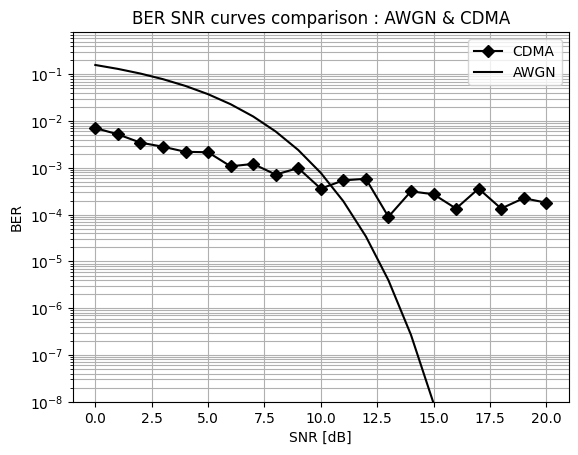

In [55]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1234
alpha = 0
ber = np.zeros(len(ebn0))
tendancy = []
previous_ber = 0

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    ber_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # IT will be used with the Gold codes to represent the ICI.
        signalOtherCells = np.zeros(encoded.shape[0])
        for k in range(encoded.shape[0]):
            signalOtherCells[k] = random.randint(0, 1)
        signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # The received signal expression will thus be the following line.
        # A sum of the encoded data passing through the channel, some random noise and some random interferences.
        # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
        received = encoded*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

        # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
        mmse = utils.MyMMSE(encoded, h, var_noise, received)
        decoded = utils.CDMA_decode(mmse, tx_params)

        # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
        decoded_tf = tf.convert_to_tensor(decoded)
        decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
        BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
        ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
        ber_i[j] = ber_j.numpy()
        
    # Compute the final BER mean value for a specific SNR.
    ber[i] = np.mean(ber_i)

    # For sake of having a nice plot, if the BER=0 due to numerical computations,
    # we change its value with the current tendancy.
    if i>0:
        tendancy.append(abs(ber[i]-previous_ber))
    if ber[i]<1e-6:
        ber[i]=abs(previous_ber-np.mean(tendancy))
    previous_ber = ber[i]

    # A nice print to see the BER result for each Eb/N0 value.
    print("Eb/N0 = " + str(ebn0[i]) + ", " + " "*(i<10) + "BER = " + f"{ber[i]:.9f}")

ber_awgn = (1/2)*erfc(np.sqrt(10**(0.1*ebn0)/2))

plt.figure()
plt.semilogy(ebn0, ber, "D-", label="CDMA", color="black")
plt.plot(ebn0, ber_awgn, label="AWGN", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.ylim([10**(-8), 0.8])
plt.title("BER SNR curves comparison : AWGN & CDMA")
plt.savefig("CDMA-images/MyBERSNR.png")
plt.show()

*Let's discover the variability of the CDMA method in function of its main parameters. We will begin this kind of dependancy analysis with varying the number of UE in the scenario.*

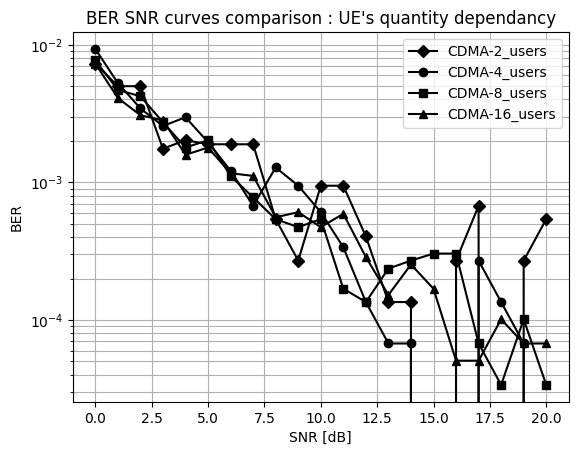

In [44]:
# Varying the number of UE in the scenario.
UserEquipements = [2, 4, 8, 16]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1234
alpha = 0
ber = np.zeros(len(ebn0))
tendancy = []
previous_ber = 0

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "s-", "^-"]

for user in range(len(UserEquipements)):

    # Setting up the current number of UE in the tx_params dictionary.
    tx_params["nMessage"] = UserEquipements[user]

    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        ber_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # IT will be used with the Gold codes to represent the ICI.
            signalOtherCells = np.zeros(encoded.shape[0])
            for k in range(encoded.shape[0]):
                signalOtherCells[k] = random.randint(0, 1)
            signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # The received signal expression will thus be the following line.
            # A sum of the encoded data passing through the channel, some random noise and some random interferences.
            # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
            received = encoded*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

            # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
            mmse = utils.MyMMSE(encoded, h, var_noise, received)
            decoded = utils.CDMA_decode(mmse, tx_params)

            # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
            decoded_tf = tf.convert_to_tensor(decoded)
            decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
            BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
            ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
            ber_i[j] = ber_j.numpy()
            
        # Compute the final BER mean value for a specific SNR.
        ber[i] = np.mean(ber_i)

        # For sake of having a nice plot, if the BER=0 due to numerical computations,
        # we change its value with the current tendancy.
        if i>0:
            tendancy.append(abs(ber[i]-previous_ber))
        if ber[i]<1e-6:
            ber[i]=abs(previous_ber-np.mean(tendancy))
        previous_ber = ber[i]

    # A nice plot of the corresponding BER/SNR curve for the current UE.
    plt.semilogy(ebn0, ber, symbols[user], label="CDMA-"+str(UserEquipements[user])+"_users", color="black")

plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curves comparison : UE's quantity dependancy")
plt.savefig("CDMA-images/MyBERSNRuser.png")
plt.show()

# Reset of the initial UE number.
tx_params["nUsers"] = 3

*Let's investigate if the length of the actual message sent by the BS will change the BER metric significantly.*

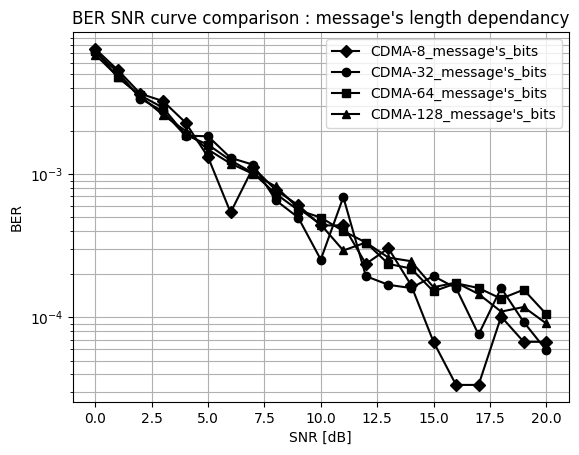

In [45]:
# Varying the number of bits in the message in the scenario.
message = [8, 32, 64, 128]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1234
alpha = 0
ber = np.zeros(len(ebn0))
tendancy = []
previous_ber = 0

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "s-", "^-"]

for mes in range(len(message)):

    # Setting up the current message length in the tx_params dictionary.
    tx_params["nMessage"] = message[mes]

    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        ber_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # IT will be used with the Gold codes to represent the ICI.
            signalOtherCells = np.zeros(encoded.shape[0])
            for k in range(encoded.shape[0]):
                signalOtherCells[k] = random.randint(0, 1)
            signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # The received signal expression will thus be the following line.
            # A sum of the encoded data passing through the channel, some random noise and some random interferences.
            # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
            received = encoded*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

            # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
            mmse = utils.MyMMSE(encoded, h, var_noise, received)
            decoded = utils.CDMA_decode(mmse, tx_params)

            # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
            decoded_tf = tf.convert_to_tensor(decoded)
            decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
            BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
            ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
            ber_i[j] = ber_j.numpy()
            
        # Compute the final BER mean value for a specific SNR.
        ber[i] = np.mean(ber_i)

        # For sake of having a nice plot, if the BER=0 due to numerical computations,
        # we change its value with the current tendancy.
        if i>0:
            tendancy.append(abs(ber[i]-previous_ber))
        if ber[i]<1e-6:
            ber[i]=abs(previous_ber-np.mean(tendancy))
        previous_ber = ber[i]

    # A nice plot of the corresponding BER/SNR curve for the current message's length.
    plt.semilogy(ebn0, ber, symbols[mes], label="CDMA-"+str(message[mes])+"_message's_bits", color="black")

plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curve comparison : message's length dependancy")
plt.savefig("CDMA-images/MyBERSNRmessage.png")
plt.show()

# Reset of the initial message's number of bits.
tx_params["nMessage"] = 6

*To counter the ICI we use Gold codes as said before. But what would happen if we skip this important step in the precoding? Let's discover it.*

In [56]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 2000
alpha = 0
ber = np.zeros(len(ebn0))
ber_Gold = np.zeros(len(ebn0))
tendancy = []
tendancy_Gold = []
previous_ber = 0
previous_ber_Gold = 0

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    ber_i = np.zeros(nb_seq)
    ber_Gold_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # IT will be used with the Gold codes to represent the ICI.
        signalOtherCells = np.zeros(encoded.shape[0])
        for k in range(encoded.shape[0]):
            signalOtherCells[k] = random.randint(0, 1)
        signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # The received signal expression will thus be the following line.
        # A sum of the encoded data passing through the channel, some random noise and some random interferences.
        # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
        received = encoded*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        received_Gold = encoded*h + n + signalOtherCells

        # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
        mmse = utils.MyMMSE(encoded, h, var_noise, received)
        mmse_Gold = utils.MyMMSE(encoded, h, var_noise, received_Gold)
        decoded = utils.CDMA_decode(mmse, tx_params)
        decoded_Gold = utils.CDMA_decode(mmse_Gold, tx_params)

        # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
        decoded_tf = tf.convert_to_tensor(decoded)
        decoded_Gold_tf = tf.convert_to_tensor(decoded_Gold)
        decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
        decoded_Gold_tf = tf.cast(tf.less(0.0, decoded_Gold_tf), tf.float32)
        BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
        ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
        ber_Gold_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_Gold_tf)
        ber_i[j] = ber_j.numpy()
        ber_Gold_i[j] = ber_Gold_j.numpy()
        
    # Compute the final BER mean value for a specific SNR.
    ber[i] = np.mean(ber_i)
    ber_Gold[i] = np.mean(ber_Gold_i)

    # For sake of having a nice plot, if the BER=0 due to numerical computations,
    # we change its value with the current tendancy.
    if i>0:
        tendancy.append(abs(ber[i]-previous_ber))
        tendancy_Gold.append(abs(ber_Gold[i]-previous_ber_Gold))
    if ber[i]<1e-6 or ber_Gold[i]<1e-6:
        ber[i]=abs(previous_ber-np.mean(tendancy))
        ber_Gold[i]=abs(previous_ber_Gold-np.mean(tendancy_Gold))
    previous_ber = ber[i]
    previous_ber_Gold = ber_Gold[i]

plt.figure()
plt.semilogy(ebn0, ber, "D-", label="CDMA", color="black")
plt.semilogy(ebn0, ber_Gold, "^-", label="CDMA-Without_Gold_codes", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curves comparison : With or without Gold codes")
plt.savefig("CDMA-images/MyBERSNR-withoutGoldComparison.png")
plt.show()

KeyboardInterrupt: 

*Another metric to investigate on is the spectral efficiency of the CDMA method. To do so, as done before, we will iterate on a lot of communications and compute the mean of the capacity for a large number of SNR values.*

In [57]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the spectral efficiency.
ebn0 = np.arange(0, 21, 1)
nb_seq = tx_params["nMessage"]*tx_params["nCodeCDMA"]
alpha = 0
spectral_efficiency = np.zeros(len(ebn0))
p_power = 1

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and spectral_efficiency_i is an array used to compute the final spectral efficiency mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    spectral_efficiency_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # IT will be used with the Gold codes to represent the ICI.
        signalOtherCells = np.zeros(encoded.shape[0])
        for k in range(encoded.shape[0]):
            signalOtherCells[k] = random.randint(0, 1)
        signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # Compute the spectral efficiency by using the allocated power and the channel coefficients.
        # But also using the noise and interference values.        
        i_interference = signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        spectral_efficiency_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(abs(n[j])**2+i_interference[j]))
    
    # Compute the final spectral efficiency mean value for a specific SNR.
    spectral_efficiency[i] = np.mean(spectral_efficiency_i)

plt.figure()
plt.plot(ebn0, spectral_efficiency, "D-", label="CDMA-Spectral_efficiency", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("Spectral Efficiency [bits/sec/Hz]")
plt.xscale("linear")
plt.grid(which="both")
plt.legend()
plt.title("Spectral efficiency curve of the used CDMA method")
plt.savefig("CDMA-images/Myspectralefficiency.png")
plt.show()

0.34284803672378766
(1.6898401360452064+0.43993829709200016j)
-0.125
1.891716255515106
(1.151581562006977+0.9163740151061458j)
-0.125
6.796468245094415
(-0.07592760471615592+0.6848838880301829j)
0.125
1.7072744978070344
(-0.06734550530739304-1.1962989517926599j)
0.125
0.2962834271295655
(-0.49740275924655664-0.671581635776399j)
-0.125
1.8215118991497186
(0.40279812747474447-0.8403370323707375j)
0.125
0.38230530585266886
(-0.21666995864346006+0.4116721613705739j)
0.125
0.21307554086176694
(-0.358308030487026+0.20972330434539777j)
-0.125
1.064181338585984
(-0.6750193694530398-0.12005396005523152j)
-0.125
1.5456622803425353
(-1.2379306205881897+0.4747420680691136j)
-0.125
13.519805028251033
(0.13003047292412914+0.008889245263598765j)
0.125
1.8333542087204673
(-0.36051865283855344+0.22572858723366288j)
-0.125
2.5397075329606835
(0.5946444257045581-0.23060145035938173j)
-0.125
3.0440326569555864
(1.1749282369241767+0.953225393216634j)
0.125
1.5264161138609393
(0.14724469696524628-0.36057438

C:\Users\Dell\AppData\Local\Temp\ipykernel_13156\2030987749.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  spectral_efficiency_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(n[j]+i_interference[j]))


0.04133052738799688
(-0.8305707238375812-0.6510325535721064j)
-0.125
2.6912705436851914
(0.6270812008654645-0.14824175924671026j)
0.125
0.6505713901695063
(0.9619460555982607-0.4798627916783226j)
0.125
2.863681366965105
(0.22467536140358027+1.6099842255400945j)
-0.125
2.203064621665286
(0.6523081678807421+1.3636815923863508j)
0.125
0.7480544778368169
(-0.5345462488791906+1.2696565479106567j)
0.125
2.5291583793032117
(-0.08335365792726131-0.6908440854001155j)
-0.125
0.9394206198874531
(-1.6913872990771992+0.7129892550481858j)
-0.125
8.145377793352447
(-0.7547612696495827-0.5180573226128068j)
0.125
4.313671053707699
(0.5060266476702341+0.5503723608477784j)
0.125
0.9408870670077132
(-0.002187343241004953-0.15679234234610373j)
-0.125
7.286512065166721
(-0.2169610916526404+0.647472410679981j)
-0.125
10.21992608301282
(0.3180674099766334+0.3161202142232631j)
0.125
1.1322061384071767
(-0.6931384986263396-0.2444779955092461j)
-0.125
1.6424172818915428
(-0.2533354936233322-0.8695343417903596j)


KeyboardInterrupt: 

*Something else up to here?*